<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/Decision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2023-02-20 06:35:50--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 104.18.10.128, 104.18.11.128, 2606:4700::6812:a80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.10.128|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2023-02-20 06:35:51--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2023-02-20 06:35:51--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting r

In [4]:
!pip install stable-baselines3
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=b0f3183ae737f35bd3e0fcfe4f82cdd9076e06d20a9d9aa17beba7c28316e191
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.0.0
    Uninstalling importlib-metadata-6.0.0:
      Successfully uninstalled importlib-metadata-6.0.0
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [5]:
%load_ext cython

In [6]:
import numpy as np
import pandas as pd
import gym
import talib as ta
import matplotlib.pyplot as plt
import random
import math
import time
import cython
import itertools
import sys

import scipy
from sklearn.preprocessing import MinMaxScaler
from scipy import fftpack, signal

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, QuantileTransformer
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.optim import Adam
from collections import deque, namedtuple

In [126]:
class MarketData:
    @classmethod
    def initialize(cls, terms, sampling_window, data_length):
        st = time.time()
        cls.terms = terms
        cls.sampling_window = sampling_window
        cls.data_length = data_length
        cls.df = pd.DataFrame()
        cls.ts = []
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.__read_data()
        cls.logopen = list(np.log(cls.open))
        cls.loghigh = list(np.log(cls.high))
        cls.loglow = list(np.log(cls.low))
        cls.logclose = list(np.log(cls.close))
        cls.close_change_ratio = list(np.array(pd.DataFrame(cls.close).pct_change().values.tolist()).reshape(len(cls.close)))
        cls.logclose_change_ratio = list(np.array(pd.DataFrame(cls.logclose).pct_change().values.tolist()).reshape(len(cls.logclose)))
        cls.log_ohlc = {} #term1:list, terms2:list....
        cls.ma_kairi = {}
        cls.rsi = {}
        cls.williams_R = {}
        cls.macd = {}
        cls.aroon_os = {}
        cls.cci = {}
        cls.dx = {}
        cls.stochastic = {}
        cls.cmo = {}
        cls.adxr = {}
        cls.apo = {}
        cls.plus_minus_di = {}
        cls.ppo = {}
        cls.ultosc = {}
        cls.__calc_index()
        cls.all_index = {}
        #cls.__calc_all_index()

        cls.sampled_ts = []
        cls.std = []
        cls.skew = []
        cls.kurtosis = []
        cls.mean = []
        cls.median = []
        cls.mode = []
        cls.max_min_ratio = []
        cls.total_change_ratio = []
        cls.period_change_ratio = []
        cls.max_end_ratio = []
        cls.min_end_ratio = []
        cls.sampled_data = []
        #cls.__get_sampling_data()
        print('Completed Market Data, time=', time.time() - st)
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])

    @classmethod
    def __calc_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)
            cls.rsi[term] = cls.__calc_rsi(term)
            cls.williams_R[term] = cls.__calc_williams_R(term)
            cls.macd[term] = cls.__calc_macdfix(term)
            cls.aroon_os[term] = cls.__calc_aroon_os(term)
            cls.cci[term] = cls.__calc_cci(term)
            cls.dx[term] = cls.__calc_dx(term)
            cls.stochastic[term] = cls.__calc_stochastic(term)
            cls.cmo[term] = cls.__calc_cmo(term)
            cls.adxr[term] = cls.__calc_adxr(term)
            cls.apo[term] = cls.__calc_apo(term)
            cls.plus_minus_di[term] = cls.__calc_plus_minus_di(term)
            cls.ppo[term] = cls.__calc_ppo(term)
            cls.ultosc[term] = cls.__calc_ultosc(term)

    #sklearn minmax scalerよりもこっちの方が少しだけ早い
    @classmethod
    def __minmax_scaler(cls, data):
        data_min = np.min(data)
        data_max = np.max(data)
        data_scaled = (data - data_min) / (data_max - data_min)
        return data_scaled

    @classmethod
    def __data_sampler(cls, current_ind:int, term:int, num_nn_units:int):
        sampling_rate = int(term / num_nn_units)
        sampling_indices = np.arange(current_ind - term, current_ind, sampling_rate)
        return np.array(MarketData.logclose)[sampling_indices]

    @classmethod
    def get_nn_input(cls, current_ind:int, num_nn_units:int, short_term:int, mid_term1:int, mid_term2:int, long_term1:int, long_term2:int):
        short_data = cls.__data_sampler(current_ind, short_term, num_nn_units)
        mid_data1 = cls.__data_sampler(current_ind, mid_term1, num_nn_units)
        mid_data2 = cls.__data_sampler(current_ind, mid_term2, num_nn_units)
        long_data1 = cls.__data_sampler(current_ind, long_term1, num_nn_units)
        long_data2 = cls.__data_sampler(current_ind, long_term2, num_nn_units)
        rsi = [MarketData.rsi[x][current_ind] for x in list(MarketData.rsi.keys())]
        res = [cls.__minmax_scaler(short_data), cls.__minmax_scaler(mid_data1), cls.__minmax_scaler(mid_data2), cls.__minmax_scaler(long_data1), cls.__minmax_scaler(long_data2)]
        return np.array(list(np.array(res).flatten()) + list(rsi))


    @classmethod
    def __calc_all_index(cls):
        for term in cls.terms:
            cls.all_index['ma_kairi_'+str(term)] = cls.__calc_ma_kairi(term)
            cls.all_index['rsi_'+str(term)] = cls.__calc_rsi(term)
            cls.all_index['williams_R_'+str(term)] = cls.__calc_williams_R(term)
            cls.all_index['macd_'+str(term)] = cls.__calc_macdfix(term)
            cls.all_index['aroon_os_'+str(term)] = cls.__calc_aroon_os(term)
            cls.all_index['cci_'+str(term)] = cls.__calc_cci(term)
            cls.all_index['dx_'+str(term)] = cls.__calc_dx(term)
            cls.all_index['stochastic_'+str(term)] = cls.__calc_stochastic(term)
            cls.all_index['cmo_'+str(term)] = cls.__calc_cmo(term)
            cls.all_index['adxr_'+str(term)] = cls.__calc_adxr(term)
            cls.all_index['apo_'+str(term)] = cls.__calc_apo(term)
            cls.all_index['di_'+str(term)] = cls.__calc_plus_minus_di(term)
            cls.all_index['ppo_'+str(term)] = cls.__calc_ppo(term)
            cls.all_index['ultosc_'+str(term)] = cls.__calc_ultosc(term)

    #initialize index after obtained converted data for NN input
    @classmethod
    def initialize_index_data(cls):
        cls.ma_kairi = {}
        cls.rsi = {}
        cls.williams_R = {}
        cls.macd = {}
        cls.aroon_os = {}
        cls.cci = {}
        cls.dx = {}
        cls.stochastic = {}
        cls.cmo = {}
        cls.adxr = {}
        cls.apo = {}
        cls.plus_minus_di = {}
        cls.ppo = {}
        cls.ultosc = {}
        cls.all_index = {}

    @classmethod
    def __get_sampling_data(cls):
        count = 0
        current_start = 0
        while True:
            data = cls.close[current_start : current_start + cls.data_length]
            change_ratio = data / np.roll(data, 1)
            change_ratio = change_ratio[1:]
            maxv = max(data)
            minv = min(data)
            cls.sampled_ts.append(cls.ts[current_start + cls.data_length - 1])
            cls.mean.append(np.mean(change_ratio))
            cls.std.append(np.std(change_ratio))
            cls.skew.append(scipy.stats.skew(change_ratio))
            cls.kurtosis.append(scipy.stats.kurtosis(change_ratio))
            cls.mode.append(scipy.stats.mode(change_ratio)[0][0])
            cls.max_min_ratio.append(maxv / minv)
            cls.period_change_ratio.append(data[-1] / data[0])
            cls.total_change_ratio.append(100 * np.mean(np.diff(data) / np.mean(data)))
            cls.max_end_ratio.append(data[-1] / maxv)
            cls.max_end_ratio.append(data[-1] / minv)
            current_start += cls.sampling_window
            if current_start + cls.data_length >= len(cls.close):
                break
        for i in range(len(cls.sampled_ts)):
            cls.sampled_data.append([cls.mean[i], cls.std[i], cls.skew[i], cls.kurtosis[i], cls.mode[i], cls.max_min_ratio[i],
                                     cls.period_change_ratio[i], cls.total_change_ratio[i], cls.max_end_ratio[i],
                                     cls.max_end_ratio[i]])


    @classmethod
    def __calc_ma_kairi(cls, term):
        ma = list(ta.MA(np.array(cls.close, dtype='f8'), timeperiod=term))
        return list(map(lambda c, e: (c - e) / e, np.array(cls.close, dtype='f8'), np.array(ma, dtype='f8')))
    
    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.logclose, dtype='f8'), timeperiod=term) / 100.0
    
    @classmethod
    def __calc_williams_R(cls, term):
        return list(ta.WILLR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'),timeperiod=term))
        
    @classmethod
    def __calc_macdfix(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.logclose, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'), np.array(signalperiod, dtype='i8'))
        return macd

    @classmethod
    def __calc_aroon_os(cls, term):
        return list(ta.AROONOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_cci(cls, term):
        return list(ta.CCI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_dx(cls, term):
        return list(ta.DX(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_stochastic(cls, term):
        k_term = term
        d_term = int(term / 2.0)
        fastk, fastd = ta.STOCHF(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), fastk_period=k_term, fastd_period=d_term, fastd_matype=0)
        return list(np.array(fastk) / np.array(fastd))


    @classmethod
    def __calc_cmo(cls, term):
        return list(ta.CMO(np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_adxr(cls, term):
        return ta.ADXR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)

    @classmethod
    def __calc_apo(cls, term):
        fperiod=term
        speriod=term * 2
        return ta.APO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_plus_minus_di(cls, term):
        mdi = ta.MINUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        pdi = ta.PLUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        return list(np.array(mdi) / np.array(pdi))

    @classmethod
    def __calc_ppo(cls, term):
        fperiod = term
        speriod = term * 2
        return ta.PPO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_ultosc(cls, term):
        p2 = int(term / 2.0)
        p1 = int(term / 3.0)
        return ta.ULTOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod1=p1, timeperiod2=p2, timeperiod3=term)

sampling_window = 1
data_length = 60
MarketData.initialize([5, 60, 240, 1440, 10080], sampling_window, data_length)

<ipython-input-126-10d9c76be7ac>:216: RuntimeWarning: invalid value encountered in true_divide
  return list(np.array(fastk) / np.array(fastd))


Completed Market Data, time= 69.36097145080566


In [ ]:
################################################################################
################################ Convert Market Data #################################
################################################################################
class MarketDataConverter:
    def start(self, corr_kijun:float):
        self.corr_kijun = corr_kijun
        all_target_keys = self.select_low_corr()
        all_converted_data = self.convert_data(all_target_keys)
        return all_converted_data

    def select_low_corr(self):
        #set all index keys
        all_index_keys = {}
        target_all_index = []
        for key in list(MarketData.all_index.keys()):
            all_index_keys[key] = True
            target_all_index.append(key)
        #check corr with close price
        price_corr = {}
        num_removed_high_price_corr = 0
        for key in list(MarketData.all_index.keys()):
            price_corr[key] = np.corrcoef(MarketData.all_index[key][1000:], MarketData.logclose[1000:])
            if abs(price_corr[key][0][1]) >= self.corr_kijun:
                all_index_keys[key] = False
                target_all_index.remove(key)
                num_removed_high_price_corr += 1
        print('Removed ', num_removed_high_price_corr, ' index correlated with price.')
        #remove all highly correlated index
        target_index = ''
        checked_key = []
        for k in all_index_keys.keys():
            if all_index_keys[key] == True:
                target_index = key
                break
        df = pd.DataFrame(MarketData.all_index)
        df_corr = df.corr()
        num_removed_high_index_corr = 0
        while True:
            checked_key.append(target_index)
            for col in df_corr.columns:
                if target_index != col and all_index_keys[col] == True:
                    if abs(df_corr[col][target_index]) >= self.corr_kijun:
                        all_index_keys[col] = False
                        num_removed_high_index_corr += 1
                        target_all_index.remove(col)
            if len(set(checked_key) ^ set(target_all_index)) > 0:
                sabun = list(set(checked_key) ^ set(target_all_index))
                target_index = random.choice(sabun)
            else:
                break
        print('Removed ', num_removed_high_index_corr, '  index correlated with other index.')
        return all_index_keys
            
    def convert_data(self, all_target_keys:list):
        converted_all_index = {}
        for k in all_target_keys:
            sorted_list = sorted(MarketData.all_index[k])
            maxv = sorted_list[int(-len(MarketData.all_index[k]) * 0.01)]
            minv = sorted_list[int(-len(MarketData.all_index[k]) * 0.99)]
            con = []
            for v in MarketData.all_index[k]:
                if v >= maxv or v <= minv:
                    v = min(max(v, maxv),minv)
                con.append(v)
            con = np.array(con).reshape(-1,1)
            scaler = MinMaxScaler()
            scaler.fit(con)
            data_scaled = scaler.transform(con)
            converted_all_index[k] = data_scaled
        return converted_all_index

mdc = MarketDataConverter()
con_marketdata = mdc.start(0.8)
MarketData.initialize_index_data()

Removed  0  index correlated with price.
Removed  13   index correlated with other index.


In [ ]:
################################################################################
################################ Trading Environment #################################
################################################################################
%%cython -a
import numpy as np
import random
cimport numpy as cnp

cdef class AccountEnv:
    cdef public double is_done_pnl_ratio
    cdef public double cash
    cdef public double market_order_fee
    cdef public double limit_order_fee
    cdef public double total_fee
    cdef public int duration
    cdef public int order_distribution_num
    cdef public dict position
    cdef public list buy_orders
    cdef public list sell_orders
    cdef public list order_ids
    cdef public int order_id_last
    cdef public double realized_pnl
    cdef public double unrealized_pnl
    cdef public int num_trade
    cdef public int num_win
    cdef public double win_rate
    cdef public double ptlc_ratio_start
    cdef public double ptlc_ratio_end
    cdef public double order_ratio_start
    cdef public double order_ratio_end
    cdef public int buy_order_var_type
    cdef public int sell_order_var_type
    cdef public double order_stop_loss_ratio
    cdef public double order_take_profit_ratio
    cdef public double pt_price
    cdef public double lc_price

    cdef public list log_total_pnl

    cdef public double state_scaler_min #to rescale order price divergence, unrealized pnl ratio, -0.1
    cdef public double state_scaler_max #0.1
    cdef public int state_scaler_bin

    cdef public double reward
    cdef public dict state
    cdef public int is_done #0:false, 1:true
    
    '''
    ptlc_ratio_start = should be 0.01 - 0.05 (should be largar than limit order fee)
    ptlc_ratio_end = should be larger than ptlc_ratio_start, 
    order_ratio_start = 0.001 - 0.01
    order_ratio_end = 
    '''
    def __cinit__(self, is_done_pnl_ratio:double, market_order_fee:double, limit_order_fee:double, order_distribution_num:int, ptlc_ratio_start:double, ptlc_ratio_end:double, order_ratio_start:double, order_ratio_end:double):
        self.cash = 10000 #always 
        self.state_scaler_min = -0.05
        self.state_scaler_max = 0.05
        self.state_scaler_bin = 10

        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.market_order_fee = market_order_fee #0.01
        self.limit_order_fee = limit_order_fee #0.006
        self.order_distribution_num = order_distribution_num
        self.ptlc_ratio_start = ptlc_ratio_start
        self.ptlc_ratio_end = ptlc_ratio_end
        self.order_ratio_start = order_ratio_start #0.005
        self.order_ratio_end = order_ratio_end #0.05
        self.reset()


    cpdef tuple reset(self):
        self.realized_pnl = 0
        self.unrealized_pnl = 0
        self.num_trade = 0
        self.num_win = 0
        self.win_rate = 0
        self.duration = 0
        self.total_fee = 0
        self.duration = 0
        self.log_total_pnl = []
        self.__initialize_position()
        self.__initialize_order()
        self.is_done = self.__check_is_done()
        self.reward = self.__calc_reward()
        self.state = self.__generate_state([1,1,1,1])
        return (self.state, self.reward, self.is_done)

    '''
    取ったアクションが将来の利益にプラスかマイナスかで判断したい。
    order出すことに報酬を出したい。
    order出しておらず何もしていない時はマイナスの報酬を与える。
    '''
    cpdef int __calc_reward(self):
        if len(self.log_total_pnl) > 2:
            if self.log_total_pnl[-1] == self.log_total_pnl[-2]:
                return 0
            elif self.log_total_pnl[-1] > self.log_total_pnl[-2]:
                return 1
            else:
                return -1
        else:
            return 0


    cpdef dict __generate_state(self, list ohlc):
        pside = np.eye(1, M=3, k=1+self.position['side'])[0]
        pperiod = min((self.position['period'] - 300) / 300, 1)
        pperiod = self.__scale_data(pperiod)
        buy_order_start_divergened = 0 if len(self.buy_orders) == 0 else self.buy_orders[0]['price'] / ohlc[3]
        buy_order_start_divergened = self.__scale_data(buy_order_start_divergened)
        buy_order_end_divergened = 0 if len(self.buy_orders) == 0 else self.buy_orders[-1]['price'] / ohlc[3]
        buy_order_end_divergened = self.__scale_data(buy_order_end_divergened)
        sell_order_start_divergened = 0 if len(self.sell_orders) == 0 else self.sell_orders[0]['price'] / ohlc[3]
        sell_order_start_divergened = self.__scale_data(sell_order_start_divergened)
        sell_order_end_divergened = 0 if len(self.sell_orders) == 0 else self.sell_orders[-1]['price'] / ohlc[3]
        sell_order_end_divergened = self.__scale_data(sell_order_end_divergened)
        buy_var_type = np.eye(1, M=6, k=1+self.buy_order_var_type)
        sell_var_type = np.eye(1, M=6, k=1+self.sell_order_var_type)
        pt_divergence = 0 if self.pt_price == 0 else self.pt_price / ohlc[3]
        pt_divergence = self.__scale_data(pt_divergence)
        lc_divergence = 0 if self.lc_price == 0 else self.lc_price / ohlc[3]
        lc_divergence = self.__scale_data(lc_divergence)
        unrealized_pnl = 0
        if self.position['side'] == 1:
            unrealized_pnl = (ohlc[3] - self.position['price']) / self.position['price']
        elif self.position['side'] == -1:
            unrealized_pnl = (self.position['price'] - ohlc[3]) / self.position['price']
        unrealized_pnl = self.__scale_data(unrealized_pnl)
        return {'position':pside, 'period':pperiod, 'buy_order_start':buy_order_end_divergened, 'buy_order_end':buy_order_end_divergened, 
                'sell_order_start':sell_order_end_divergened, 'sell_order_end':sell_order_end_divergened, 
                'pt':pt_divergence, 'lc':lc_divergence, 'unrealized_pnl':unrealized_pnl}

    cpdef cnp.ndarray __scale_data(self, double actual_v):
        return np.histogram([actual_v], bins=self.state_scaler_bin, range=(self.state_scaler_min, self.state_scaler_max))[0]
        

    cpdef void __initialize_order(self):
        self.buy_orders = [] #{'id', 'side', 'type', 'price', 'size'} side:1 or -1, type:0:market, 1:limit, size:percentage (0-1)
        self.sell_orders = []
        self.buy_order_var_type = -1 #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        self.sell_order_var_type = -1 #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        self.order_ids = []
        self.order_id_last = 0
        self.order_stop_loss_ratio = 0
        self.order_take_profit_ratio = 0
        self.pt_price = 0
        self.lc_price = 0

    '''
    Assumed buy/sell order is always in A-Z order and executed from A
    '''
    cpdef void __remove_order(self, int oside):
        if oside == 1:
            del self.buy_orders[0]
            self.buy_order_var_type = -1
        else:
            del self.sell_orders[0]
            self.sell_order_var_type = -1

    cpdef void __initialize_position(self):
        self.position = {'side':0, 'price':0, 'size':0, 'start_duration':0, 'period':0} #side (0:none, 1:buy, -1:sell)
    
    cpdef void __update_position(self, int side, double size, double price, int start_duration, int period):
        self.position = {'side':side, 'size':size, 'price':price, 'start_duration':self.duration, 'period':period}

    '''
    price_start_ratio, price_end_ratio: i.e. start = 0.01, end = 0.01, current price= 10000 then order = [10100, 10120,,,, 10201]
    '''
    cpdef tuple step(self, int action, int order_var_type, double price_start_ratio, double price_end_ratio, double pt_ratio, double lc_ratio, list ohlc):
        #action = 0:nothing, 1:buy, 2:sell, 3:pt, 4:lc, 5:cancel buy, 6:cancel sell, 7:market close
        #Buy: price start ratio,  price end ratio= (0.01 - 0.05)
        #Sell: price start ratio,  price end ratio= (0.01 - 0.05)
        #pt_ratio = (0.01 - 0.05)
        #lc_ratio = (0.005 - 0.05)
        #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        #
        if self.position['side'] != 0:
            self.position['period'] += 1

        if self.position['side'] == 0 and len(self.buy_orders) == 0 and action == 1:#entry buy limit order
            self.__entry_order(1, 1, price_start_ratio, price_end_ratio, order_var_type, ohlc)
        elif self.position['side'] == 0 and len(self.sell_orders) == 0 and action == 2:#entry sell limit order
            self.__entry_order(1, -1, price_start_ratio, price_end_ratio, order_var_type, ohlc) 
        elif self.position['side'] != 0  and action == 3:#place pt order
            self.__entry_pt_order(pt_ratio)
        elif self.position['side'] != 0 and action == 4: #place lc order
            self.__entry_lc_order(lc_ratio)
        elif len(self.buy_orders) > 0 and action == 5:#cancel buy
            self.__cancel_order(1)
        elif len(self.sell_orders) > 0 and action == 6:#cancel sell
            self.__cancel_order(-1)
        elif self.position['side'] != 0 and action == 7:
            self.__exit_all(ohlc)
        self.__check__execution(ohlc)
        self.__update_cash_pnl(ohlc)
        self.__update_performance(ohlc)
        self.__take_log(ohlc)
        self.duration += 1
        self.is_done = self.__check_is_done()
        self.reward = self.__calc_reward()
        self.state = self.__generate_state(ohlc)
        return (self.state, self.reward, self.is_done, 0)
    
    cpdef int __check_is_done(self):
        if self.is_done_pnl_ratio <= (self.realized_pnl + self.unrealized_pnl - self.total_fee) / self.cash:
            return 0
        else:
            return 1

    cpdef void __update_cash_pnl(self, ohlc):
        if self.position['side'] != 0:
            self.unrealized_pnl = self.position['size'] *  (ohlc[3] - self.position['price']) / self.position['price'] if self.position['side'] == 1 else self.position['size'] *  (self.position['price'] - ohlc[3]) / self.position['price']
        else:
            self.unrealized_pnl = 0

    cpdef void __update_performance(self, ohlc):
        if self.num_trade > 0:
            self.win_rate = self.num_win / self.num_trade

    cpdef void __take_log(self, ohlc):
        self.log_total_pnl.append(self.realized_pnl + self.unrealized_pnl - self.total_fee)

    cpdef tuple action_space_sample(self):
        action_id = random.randint(0,7)
        order_var_type = random.randint(0, 4)
        buy_order_price_start = random.randint(-100, 100) / 100.0
        sell_order_price_start = random.randint(-100, 100) / 100.0
        pt_ratio = random.randint(-100, 100) / 100.0
        lc_ratio = random.randint(-100, 100) / 100.0
        action = (action_id, order_var_type, buy_order_price_start, sell_order_price_start, pt_ratio, lc_ratio)
        return action

    cpdef tuple action_space_max(self):
        return (7, 4, 1,1,1,1)
    
    cpdef tuple action_space_min(self):
        return (0, 0, -1,-1,-1,-1)

    '''
    otype should be always 1 as limit order.
    market order is allowed only for exit_all, and stop loss market order
    '''
    cpdef void __entry_order(self, int otype, int side, double price_start_ratio, double price_end_ratio, int order_var_type, list ohlc):
        order_prices = self.__generate_order_prices(side, price_start_ratio, price_end_ratio, ohlc[0])
        order_size_ditribution = self.__generate_order_percentage(order_var_type, order_prices)
        for i in range(len(order_size_ditribution)):
            if side ==1:
                self.buy_orders.append({'id':self.order_id_last, 'side':side, 'type':otype, 'price':order_prices[i], 'size':order_size_ditribution[i]})
                self.buy_order_var_type = order_var_type
            else:
                self.sell_orders.append({'id':self.order_id_last, 'side':side, 'type':otype, 'price':order_prices[i], 'size':order_size_ditribution[i]})
                self.sell_order_var_type = order_var_type
            self.order_ids.append(self.order_id_last)
            self.order_id_last += 1
    
    '''
    Assumed output val of NN for pt ratio is -1 ~ 1
    '''
    cpdef void __entry_pt_order(self, double pt_ratio):
        if self.position['side'] != 0:
            self.order_take_profit_ratio = pt_ratio * (self.ptlc_ratio_start -self.ptlc_ratio_end) / 2.0 + (self.ptlc_ratio_start+self.ptlc_ratio_end) / 2.0
            self.pt_price = self.position['price'] * (1.0 + self.order_take_profit_ratio) if self.position['side'] == 1 else self.position['price'] * (1.0 - self.order_take_profit_ratio)

    '''
    Assumed output val of NN for lc ratio is -1 ~ 1
    '''
    cpdef void __entry_lc_order(self, double lc_ratio):
        if self.position['side'] != 0:
            self.order_stop_loss_ratio = lc_ratio * (self.ptlc_ratio_start -self.ptlc_ratio_end) / 2.0 + (self.ptlc_ratio_start+self.ptlc_ratio_end) / 2.0
            self.lc_price = self.position['price'] * (1.0 - self.order_stop_loss_ratio) if self.position['side'] == 1 else self.position['price'] * (1.0 + self.order_stop_loss_ratio)


    cpdef void __exit_all(self, ohlc):
        self.__initialize_order()
        fee = self.__calc_fee(0, self.position['size'], ohlc[0])
        self.total_fee += fee
        realized_pnl= self.__calc_realized_pnl(self.position['size'], ohlc[0])
        if realized_pnl > 0:
            self.num_win +=1
        self.num_trade += 1
        self.realized_pnl += realized_pnl
        self.unrealized_pnl = 0


    cpdef cnp.ndarray __generate_order_percentage(self, int order_var_type, cnp.ndarray prices):
        order_size_ditribution = np.zeros(1)
        if order_var_type == 0: #uniform distribution
            order_size_ditribution = 1.0/self.order_distribution_num * self.cash / prices
        elif order_var_type == 1: #y=x
            order_size_ditribution = np.linspace(1, self.order_distribution_num+1, self.order_distribution_num)
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = order_size_ditribution * (self.cash / prices)
        elif order_var_type == 2: #y=-x
            order_size_ditribution = np.linspace(self.order_distribution_num+1, 1, self.order_distribution_num)
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = order_size_ditribution * (self.cash / prices)
        elif order_var_type == 3: #/\
            order_size_ditribution = np.concatenate([np.linspace(1, self.order_distribution_num+1, int(self.order_distribution_num * 0.5)), 
                                                     np.linspace(self.order_distribution_num+2, 1, self.order_distribution_num - int(self.order_distribution_num * 0.5))])
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = order_size_ditribution * (self.cash / prices)
        elif order_var_type == 4: #\/
            order_size_ditribution = np.concatenate([np.linspace(self.order_distribution_num+1, 1, int(self.order_distribution_num * 0.5)), 
                                                     np.linspace(2, self.order_distribution_num+1, self.order_distribution_num - int(self.order_distribution_num * 0.5))])
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = order_size_ditribution * (self.cash / prices)
        return order_size_ditribution


    cpdef cnp.ndarray __generate_order_prices(self, int oside, double price_start_ratio, double price_end_ratio, double current_price):
        s_ratio = price_start_ratio * (self.order_ratio_start -self.order_ratio_end) / 2.0 + (self.order_ratio_start+self.order_ratio_end) / 2.0
        e_ratio = price_end_ratio * (self.order_ratio_start -self.order_ratio_end) / 2.0 + (self.order_ratio_start+self.order_ratio_end) / 2.0
        if oside == -1:
            s = (1.0 + s_ratio) * current_price
            e = (1.0 + e_ratio) * s
            return np.linspace(s, e, self.order_distribution_num)
        else:
            s = (1.0 - s_ratio) * current_price
            e = (1.0 - e_ratio) * s
            return np.linspace(s, e, self.order_distribution_num)
    
    cpdef void __cancel_order(self, int side):
        if side == 1:
            self.buy_orders = []
        elif side == -1:
            self.sell_orders = []
        else:
            print('AccountEnv: Invalid side in cancel order !')

    '''
    0: no execution, 1:buy order exec, 2:sell order exec, 3:pt exec, 4:lc exec, 5:multiple exec
    '''
    cpdef int __check__execution(self, ohlc):
        check_prices = []
        if ohlc[3] > ohlc[0]: #yosen
            check_prices = [ohlc[2], ohlc[1]]
        else:
            check_prices = [ohlc[1], ohlc[2]]
        for p in check_prices:
            if self.order_take_profit_ratio != 0 and self.position['side'] == 1: #pt lc check for buy position
                if p > self.pt_price:
                    self.__process_pt_order(self.pt_price)
                    return 3
                elif p <= self.lc_price:
                    self.__process_lc_order(self.lc_price)
                    return 4
            elif self.order_take_profit_ratio != 0 and self.position['side'] == -1: #pt lc check for sell position            
                if p < self.pt_price:
                    self.__process_pt_order(self.pt_price)
                    return 3
                elif p >= self.lc_price:
                    self.__process_lc_order(self.lc_price)
                    return 4
            for order in self.buy_orders:
                if p < order['price']:
                    #print('buy executed: buy=', order['price'], ', price=', p)
                    self.__process_execution(order['type'], order['side'], order['id'], order['size'], order['price'])
                else:
                    break #orders are in price order (A-Z) so should be executed from A and can exit from loop if current order was not executed
            for order in self.sell_orders:
                if p > order['price']:
                    #print('sell executed: sell=', order['price'], ', price=', p)
                    self.__process_execution(order['type'], order['side'], order['id'], order['size'], order['price'])
                else:
                    break
        return 0
            
        
    
    cpdef void __process_execution(self, int otype, int oside, int oid, double size, double exec_price):
        fee = self.__calc_fee(otype, size, exec_price)
        self.total_fee += fee
        if self.position['side'] == 0: #new entry
            self.__update_position(oside, size, exec_price, self.duration, 0)
            self.__remove_order(oside)
        elif self.position['side'] != oside: #exit
            realized_pnl = self.__calc_realized_pnl(size, exec_price)
            self.realized_pnl += realized_pnl
            if self.position['size'] > size:
                self.__update_position(self.position['side'], self.position['size'] - size, self.position['price'], self.position['start_duration'], self.position['period'])
                self.__remove_order(oside)
            elif self.position['size'] == size:
                self.__initialize_position()
                self.__initialize_order()
                self.num_trade += 1
                if realized_pnl > 0:
                    self.num_win += 1
            else:
                self.__update_position(oside, size - self.position['size'], exec_price, self.duration, 0)
                self.__remove_order(oside)
                print('AccountEnv: exit and opposite entry is not allowed !')
        else: #additional entry
            updated_price = (self.position['size'] * self.position['price'] + size * exec_price) / (self.position['size'] + size)
            self.__update_position(self.position['side'], self.position['size'] + size, updated_price, self.position['start_duration'], self.position['period'])
            self.pt_price = self.position['price'] * (1.0 + self.order_take_profit_ratio) if self.position['side'] == 1 else self.position['price'] * (1.0 - self.order_take_profit_ratio)
            self.lc_price = self.position['price'] * (1.0 - self.order_stop_loss_ratio) if self.position['side'] == 1 else self.position['price'] * (1.0 + self.order_stop_loss_ratio)
        self.__remove_order(oside)


    cpdef void __process_pt_order(self, double pt_price):
        self.total_fee += self.__calc_fee(1, self.position['size'], pt_price)
        realized_pnl = self.__calc_realized_pnl(self.position['size'], pt_price)
        self.realized_pnl += realized_pnl
        self.num_trade += 1
        #print('pt executed at ', pt_price, ', pnl=', realized_pnl)
        if realized_pnl > 0:
            self.num_win += 1
        self.__initialize_position()
        self.__initialize_order()
        

    cpdef void __process_lc_order(self, double lc_price):
        self.total_fee += self.__calc_fee(0, self.position['size'], lc_price)
        realized_pnl = self.__calc_realized_pnl(self.position['size'], lc_price)
        self.realized_pnl += realized_pnl
        #print('lc executed at ', lc_price, ', pnl=', realized_pnl)
        self.num_trade += 1
        self.__initialize_position()
        self.__initialize_order()
        
    
    cpdef double __calc_fee(self, int otype, double size, double exec_price):
        if otype == 0:
            return self.market_order_fee * size * exec_price
        elif otype == 1:
            return self.limit_order_fee * size * exec_price
    
    cpdef double __calc_realized_pnl(self, double size, double exec_price):
        if self.position['side'] == 1:
            return  (exec_price - self.position['price']) / self.position['price'] * size
        elif self.position['side'] == -1:
            return (self.position['price'] - exec_price) / self.position['price'] * size
        else:
            print('AcountEnv: realized pnl should not be called when no position !')
            return 0





In [ ]:
################################################################################
################################ Positional Encoder #################################
################################################################################
class PositionalEncoder:
    def getPositionEncoding(self, seq_len, dim, n):
        p = np.zeros((seq_len, dim))
        for k in range(seq_len):
            for i in np.arange(int(dim/2)):
                denominator = np.power(n, 2*i/dim)
                p[k, 2*i] = np.sin(k/denominator)
                p[k, 2*i+1] = np.cos(k/denominator)
        return p

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

'''
t = torch.tensor(con_marketdata[list(con_marketdata.keys())[0]])
pe = PositionalEncoding(t.shape[0])
pe(t)
'''

In [ ]:
################################################################################
################################ Embedding Input #################################
################################################################################
is_done_pnl_ratio = -0.1
market_order_fee = 0.01
limit_order_fee = 0.006
order_distribution_num = 10
ptlc_ratio_start = 0.01
ptlc_ratio_end = 0.05
order_ratio_start = 0.005
order_ratio_end = 0.05


class InputEmbedding:
    def generate_initia_data(self, start_ind:int, num_length:int, env, market_index_data:dict):
        initial_embd_data = []
        state, reward, is_done = env.reset()
        for i in range(num_length):
            action = env.action_space_sample()
            ohlc = [MarketData.open[start_ind+i], MarketData.high[start_ind+i], MarketData.low[start_ind+i], MarketData.close[start_ind+i]]
            state, reward, is_done, _ = env.step(0, action[1], action[2], action[3], action[4], action[5], ohlc) #fix action type = none
            con_state = np.array(list(itertools.chain(*state.values())))
            con_action = np.concatenate([np.eye(1, M=8, k=action[0])[0], np.eye(1, M=4, k=action[1])[0], [action[2],action[3],action[4]]])
            combined = np.concatenate([con_state, con_action])
            combined = np.append(combined, np.array(reward))
            md = []
            for k in list(market_index_data.keys()):
                md.append(market_index_data[k][start_ind][0])
            initial_embd_data.append(np.concatenate([combined, np.array(md)]))
        return initial_embd_data

    def generate_embedded_input(self, market_data_ind:int, state:dict, action:dict, reward:float, market_index_data:dict):
        ohlc = [MarketData.open[market_data_ind], MarketData.high[market_data_ind], MarketData.low[market_data_ind], MarketData.close[market_data_ind]]
        con_state = np.concatenate([np.array(list(state.values())[0]), np.array(list(state.values())[1:]).flatten()])
        con_action = np.concatenate([np.eye(1, M=8, k=action[0])[0], np.eye(1, M=4, k=action[1])[0], [action[2],action[3],action[4]]])
        combined = np.concatenate([con_state, con_action])
        combined = np.append(combined, np.array(reward))
        md = []
        for k in list(market_index_data.keys()):
            md.append(market_index_data[k][market_data_ind][0])
        return np.concatenate([combined, np.array(md)])
        

#ac = AccountEnv(is_done_pnl_ratio, market_order_fee, limit_order_fee, order_distribution_num, ptlc_ratio_start, ptlc_ratio_end, order_ratio_start, order_ratio_end)
input_embedding = InputEmbedding()
#initial_embd_data = input_embedding.generate_initia_data(100000, 10, ac, con_marketdata)

action = ac.action_space_sample()
ohlc = [MarketData.open[100000], MarketData.high[100000], MarketData.low[100000], MarketData.close[100000]]
state, reward, is_done, _ = ac.step(action[0], action[1], action[2], action[3], action[4], action[5], ohlc)
next_embd_data = input_embedding.generate_embedded_input(100000, state, action, reward, con_marketdata)

In [ ]:
################################################################################
################################ Data Standardization #################################
################################################################################
class DataStandardization:
    def standardScaler(self):
        standardized_data = {}
        sc = StandardScaler()
        for key in list(MarketData.index_data.keys()):
            standardized_data[key] = sc.fit_transform(np.array(MarketData.index_data[key]).reshape(-1,1)).flatten()
        return pd.DataFrame.from_dict(standardized_data)

    def minmaxScalerMarketData(self, df, from_ind, to_ind):
        scaled_data = {}
        ms = MinMaxScaler()
        for col in df.columns:
            scaled_data[col] = ms.fit_transform(np.array(df[col]).reshape(-1,1)).flatten()
        return pd.DataFrame.from_dict(scaled_data)

    def minmaxScalerAction(self, data, from_ind, to_ind):
        scaled_data = {}
        ms = MinMaxScaler((-1, 1))
        return ms.fit_transform(np.array(data[from_ind:to_ind+1]).reshape(-1,1)).flatten()


'''        
ds = DataStandardization()
sdf = ds.standardScaler()
for col in sdf:
    plt.figure()
    plt.title(col)
    plt.plot(sdf[col])
plt.show()
'''

In [ ]:
'''
is_done_pnl_ratio = -0.1
market_order_fee = 0.01
limit_order_fee = 0.006
order_distribution_num = 10
ptlc_ratio_start = 0.01
ptlc_ratio_end = 0.05
order_ratio_start = 0.005
order_ratio_end = 0.05

ac = AccountEnv(is_done_pnl_ratio, market_order_fee, limit_order_fee, order_distribution_num, ptlc_ratio_start, ptlc_ratio_end, order_ratio_start, order_ratio_end)
ac.reset()
start_ind = 1000000
st = time.time()
for i in range(1000):
    ohlc = [MarketData.open[start_ind + i], MarketData.high[start_ind + i],MarketData.low[start_ind + i],MarketData.close[start_ind + i]]
    action = ac.action_space_sample()
    res = ac.step(action[0], action[1], action[2], action[3], action[4], action[5], ohlc)
    print('i=', res[0])
    #print('i=',i, 'close=',ohlc[3], 'side=',ac.position['side'], ', size=', ac.position['size'], ', price=',  ac.position['price'], ', reward=', res[2],  ', unrealized_pnl=', ac.unrealized_pnl, ', total pnl=', ac.realized_pnl + ac.unrealized_pnl - ac.total_fee)
print('num trade=', ac.num_trade, ', win rate=', ac.win_rate, ', pnl=', ac.realized_pnl + ac.unrealized_pnl - ac.total_fee)
print('time=', time.time()-st)
'''

In [ ]:
################################################################################
################################ Replay Memory #################################
################################################################################
Transition = namedtuple('Transition',
                        ('market_data', 'state', 'action', 'log_probs', 'reward', 'state_value'))

class ReplayMemory:
    @classmethod
    def initialize(cls, capacity):
        cls.memory = deque([], maxlen=capacity)

    @classmethod
    def push(cls, *args):
        cls.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
################################################################################
################################ network #################################
################################################################################
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Transformer(nn.Module):
    def __init__(self, inputs_shape, num_heads, dropout_ratio, device, dtype):
        #super(Transformer, self).__init__()
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=inputs_shape[-1], num_heads=num_heads, dropout=dropout_ratio, device = device, dtype = dtype)
        self.norm1 = nn.LayerNorm(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.linear1 = nn.Linear(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.softplus1 = nn.Softplus()
        self.linear2 = nn.Linear(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.softplus2 = nn.Softplus()
        self.do1 = nn.Dropout(p=dropout_ratio)
        self.norm2 = nn.LayerNorm(inputs_shape[-1], device = device, dtype = dtype)

    def forward(self, inputs):
        output = self.mha(inputs, inputs, inputs)
        output_norm = self.norm1(output[0] + inputs)
        output = self.linear1(output_norm)
        output = self.softplus1(output[0])
        output = self.linear2(output)
        output = self.do1(output)
        output = self.norm2(output + output_norm)
        return output


class Actor(nn.Module):
    def __init__(self, inputs_shape, outputs_shape, num_heads, dropout_ratio, device, dtype):
        #super(Bert, self).__init__()
        super().__init__()
        self.transformer1 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer2 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer3 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer4 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer5 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer6 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.flatten1 = nn.Flatten()
        self.linear1 = nn.Linear(inputs_shape[-1] * inputs_shape[-2], outputs_shape[-1], device = device, dtype = dtype)
        

    def forward(self, inputs):
        output = self.transformer1(inputs)
        output = self.transformer2(output)
        output = self.transformer3(output)
        output = self.transformer4(output)
        output = self.transformer5(output)
        output = self.transformer6(output)
        output = self.flatten1(output)
        output = self.linear1(output)
        return output



time= 0.09108538150787354


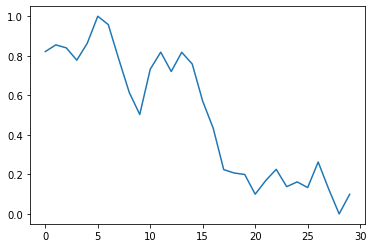

In [43]:
####################################################################################
############################### Test Code ####################################
####################################################################################
current_ind = 1000000
term = 129600
nn_input_units = 30
scaler = MinMaxScaler()

st = time.time()

def minmax_scaler(data):
    data_min = np.min(data)
    data_max = np.max(data)
    data_scaled = (data - data_min) / (data_max - data_min)
    return data_scaled

for i in range(100):
    sampling_rate = int(term / nn_input_units)
    sampling_indices = np.arange(current_ind - term, current_ind, sampling_rate)
    sampled_data = np.array(MarketData.close)[sampling_indices]

    scaler.fit(sampled_data.reshape(-1,1))
    data_scaled = scaler.transform(sampled_data.reshape(-1,1))
    #data_scaled = minmax_scaler(sampled_data)
print('time=', (time.time() - st) / 100)
plt.plot(data_scaled)

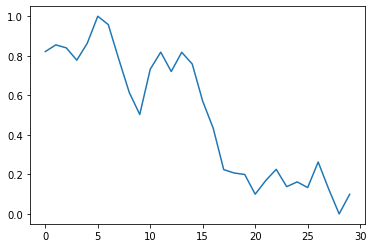

In [42]:
plt.plot(data_scaled)

In [127]:
####################################################################################
############################### Test Code ####################################
####################################################################################
data = MarketData.get_nn_input(1100000, 30, 60, 300, 3600, 14400, 129600)


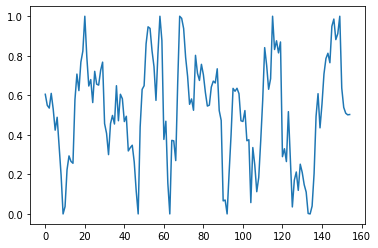

In [128]:
plt.plot(data)

In [119]:
np.array(data[0:-1]).flatten()

array([0.60516549, 0.54937006, 0.5354191 , 0.60981451, 0.5307686 ,
       0.42378131, 0.48890987, 0.34001774, 0.19568744, 0.        ,
       0.03728651, 0.22362933, 0.29346938, 0.26553588, 0.25622397,
       0.57726945, 0.70742233, 0.62376099, 0.76782568, 0.82356868,
       1.        , 0.79569886, 0.64700328, 0.67953857, 0.56332017,
       0.72136296, 0.65629954, 0.65165145, 0.72600965, 0.76782568,
       0.45687793, 0.40736048, 0.29999071, 0.45687793, 0.49812424,
       0.45481518, 0.64853286, 0.47131602, 0.60528719, 0.58262743,
       0.46719106, 0.49400035, 0.31858197, 0.33510472, 0.34749503,
       0.26279808, 0.11596236, 0.        , 0.44037477, 0.63000123,
       0.64853286, 0.8603793 , 0.94663802, 0.93842603, 0.82544445,
       0.74525486, 0.57438627, 0.81311166, 1.        , 0.87681512,
       0.37702873, 0.46890549, 0.15612264, 0.        , 0.37205266,
       0.36956425, 0.26982142, 0.66492079, 1.        , 0.98932435,
       0.93782227, 0.79245482, 0.696375  , 0.55451424, 0.58166

In [99]:

data = np.zeros(1000)
d = [1]
st = time.time()
for i in range(100):
    d=list(data)
    np.array(d)
print(time.time() - st)

0.06349587440490723


In [82]:
data[1]

array([0.45687793, 0.40736048, 0.29999071, 0.45687793, 0.49812424,
       0.45481518, 0.64853286, 0.47131602, 0.60528719, 0.58262743,
       0.46719106, 0.49400035, 0.31858197, 0.33510472, 0.34749503,
       0.26279808, 0.11596236, 0.        , 0.44037477, 0.63000123,
       0.64853286, 0.8603793 , 0.94663802, 0.93842603, 0.82544445,
       0.74525486, 0.57438627, 0.81311166, 1.        , 0.87681512])

In [83]:
data[2]

array([0.37702873, 0.46890549, 0.15612264, 0.        , 0.37205266,
       0.36956425, 0.26982142, 0.66492079, 1.        , 0.98932435,
       0.93782227, 0.79245482, 0.696375  , 0.55451424, 0.58166878,
       0.52436238, 0.80223788, 0.71159623, 0.67524613, 0.7567137 ,
       0.70374128, 0.61470763, 0.5456208 , 0.55006792, 0.64179605,
       0.67180483, 0.66246174, 0.73416527, 0.52287856, 0.47287084])

array([       nan,        nan,        nan, ..., 0.48011917, 0.49000384,
       0.48971005])